<h1 style="text-align: center; font-weight: bold;">
Experiments Model ARIMA 
</h1>

# LLibreries

In [8]:
# ============================================================================
# 📚 LLIBRERIES BÀSIQUES
# ============================================================================
import os
import json
import warnings
from pathlib import Path
from datetime import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd

pd.options.display.float_format = '{:.2f}'.format

# ============================================================================
# 📊 VISUALITZACIÓ
# ============================================================================
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import plotly.express as px

# Per mostrar gràfics inline en notebooks
%matplotlib inline

# ============================================================================
# ⚙️ MODELATGE TEMPORAL
# ============================================================================
from itertools import combinations

# Statsmodels ARIMA/SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.api as sm
import statsmodels.tsa.api as smt

# AutoARIMA
from pmdarima import auto_arima

# ============================================================================
# 📏 MÈTRIQUES
# ============================================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ============================================================================
# ⏳ ALTRES
# ============================================================================
from tqdm.notebook import tqdm  # Versió per notebooks (si és script -> tqdm normal)

# Ignorem warnings innecessaris
warnings.filterwarnings("ignore")


# ============================================================================
# Funcions pròpies
import importlib
import arima_functions
importlib.reload(arima_functions)
from arima_functions import *

# Importació Dades

Dades Carregades des del fitxer CSV netejat i guardat pel fitxer de data preprocessing

In [2]:
#Directori de treball

# Ruta on esta el script actual
__path__ = os.getcwd() # Si es fitxer .ipynb
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py

# Carpeta on es troben les dades
carpeta_dades = '../0_Data/Dades_T_estacions_xema_Z1'

# Fitxers de dades
fitxer_dades_csv = 'SCM_T_Z1.csv' # Nom del fitxer CSV amb totes les dades
fitxer_dades_csv_2009_2019 = 'SCM_T_Z1_2009_2019.csv' # Nom del fitxer CSV amb les dades de 2009 a 2019
fitxer_dades_csv_2020_2024 = 'SCM_T_Z1_2020_2024.csv' # Nom del fitxer CSV amb les dades de 2020 a 2024 (final dades)

# Path complet al fitxer CSV
path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades_csv)
path_dades_2009_2019 = os.path.join(__path__, carpeta_dades, fitxer_dades_csv_2009_2019)
path_dades_2020_2024 = os.path.join(__path__, carpeta_dades, fitxer_dades_csv_2020_2024)


# Importar les dades 2020_2024 per LSTM ja que son recents i no tenen interrupcions ni valors nuls

df_arima = pd.read_csv(path_dades_2020_2024)
df_arima_totes = pd.read_csv(path_dades)

# Convertir la columna 'data' a tipus datetime
df_arima['data'] = pd.to_datetime(df_arima['data'], utc=True)
df_arima_totes['data'] = pd.to_datetime(df_arima_totes['data'], utc=True)

# Comprovar si hi ha valors nuls
print("Valors nuls per columna en dades LSTM:")
print(df_arima.isnull().sum())

# Mostrar el df

df_arima


Valors nuls per columna en dades LSTM:
data     0
valor    0
dtype: int64


,data,valor
0,2020-01-01 00:00:00+00:00,1.30
1,2020-01-01 01:00:00+00:00,1.60
2,2020-01-01 02:00:00+00:00,3.20
3,2020-01-01 03:00:00+00:00,4.40
4,2020-01-01 04:00:00+00:00,4.00
...,...,...
43843,2024-12-31 19:00:00+00:00,0.10
43844,2024-12-31 20:00:00+00:00,-0.60
43845,2024-12-31 21:00:00+00:00,-0.60
43846,2024-12-31 22:00:00+00:00,-0.70


### Visualització Prèvia de les dades

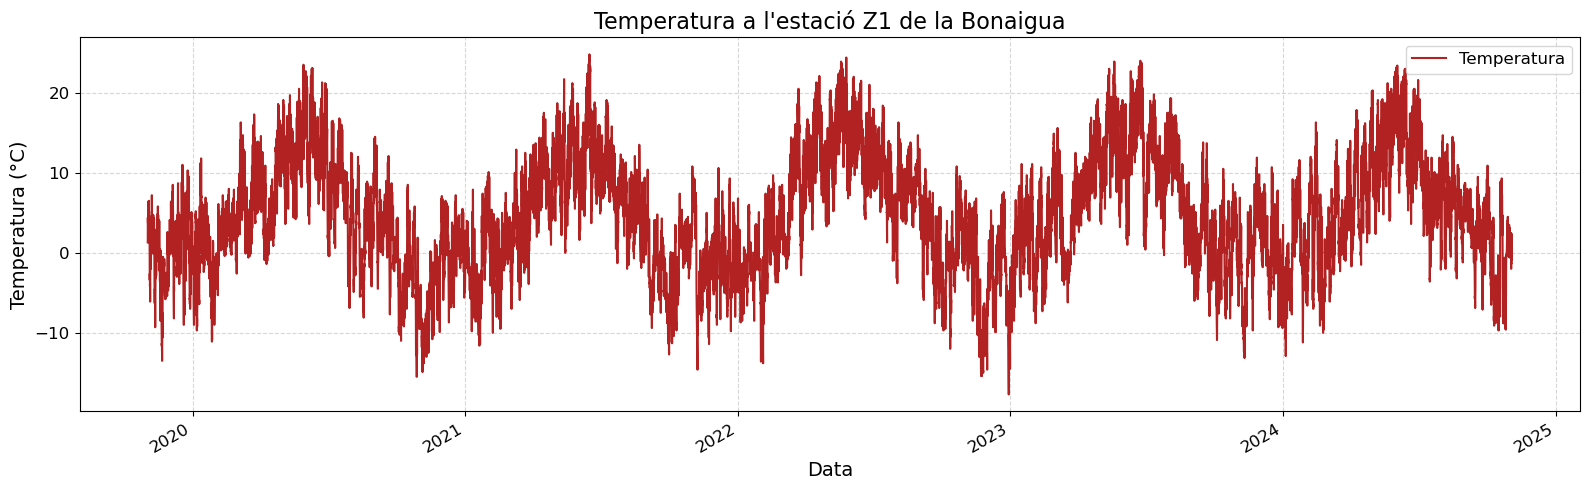

In [3]:
plt.figure(figsize=(16, 5))
plt.plot(df_arima['data'], df_arima['valor'], label='Temperatura', color='firebrick', linewidth=1.5)

# Millores visuals
plt.title('Temperatura a l\'estació Z1 de la Bonaigua', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Format de dates a l’eix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# Experimentació ARIMA usant Pipeline

In [4]:
df_train , df_test = split_train_test_arima(df_arima,
                                            data_inici_pred='2024-10-01 00:00:00',
                                            dies_entrenament=60, 
                                            data_final_pred='2024-10-05 00:00:00',
                                            verbose=True)


🔹 Split ARIMA:
  ▸ Train: 1440 valors
  ▸ Test:  97 valors


In [5]:
model = entrenar_model_arima(df_train,
                             p =10, d =1, q=10,
                             P=None, D=None, Q=None, s=None,
                             verbose=True) 

📦 Entrenant ARIMA(10,1,10) (sense component estacional)
                               SARIMAX Results                                
Dep. Variable:                  valor   No. Observations:                 1440
Model:             SARIMAX(10, 1, 10)   Log Likelihood               -1791.635
Date:                Thu, 26 Jun 2025   AIC                           3625.269
Time:                        08:19:44   BIC                           3735.975
Sample:                             0   HQIC                          3666.597
                               - 1440                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2226      0.541     -0.411      0.681      -1.283       0.838
ar.L2          0.0961      0.415      0.232      0.817      -0.717       0.

In [9]:
df_test
# ============================================================================
# Funcions pròpies
import importlib
import arima_functions
importlib.reload(arima_functions)
from arima_functions import *

In [10]:
df_pred = prediccio_arima(df_test,
                          model_fit=model,
                          n_passos=48,
                          verbose=True)

🔹 Predicció ARIMA:
  ▸ Passos predits: 48
                       data  valor  forecast
0 2024-10-01 00:00:00+00:00   8.60      8.18
1 2024-10-01 01:00:00+00:00   9.70      8.32
2 2024-10-01 02:00:00+00:00  10.20      8.59
3 2024-10-01 03:00:00+00:00  10.50      9.10
4 2024-10-01 04:00:00+00:00  10.40      9.67


In [12]:
df_pred

,data,valor,forecast
0,2024-10-01 00:00:00+00:00,8.60,8.18
1,2024-10-01 01:00:00+00:00,9.70,8.32
2,2024-10-01 02:00:00+00:00,10.20,8.59
3,2024-10-01 03:00:00+00:00,10.50,9.10
4,2024-10-01 04:00:00+00:00,10.40,9.67
5,2024-10-01 05:00:00+00:00,11.00,10.37
6,2024-10-01 06:00:00+00:00,10.50,11.01
7,2024-10-01 07:00:00+00:00,10.30,11.69
8,2024-10-01 08:00:00+00:00,11.00,12.32
9,2024-10-01 09:00:00+00:00,11.90,12.91


In [13]:
metriques = calcular_metriques_arima(df_pred, col_real='valor', col_pred='forecast', verbose=True)

📏 RMSE: 3.09 °C
📏 MSE: 9.53 °C²
📏 MAE: 2.48 °C


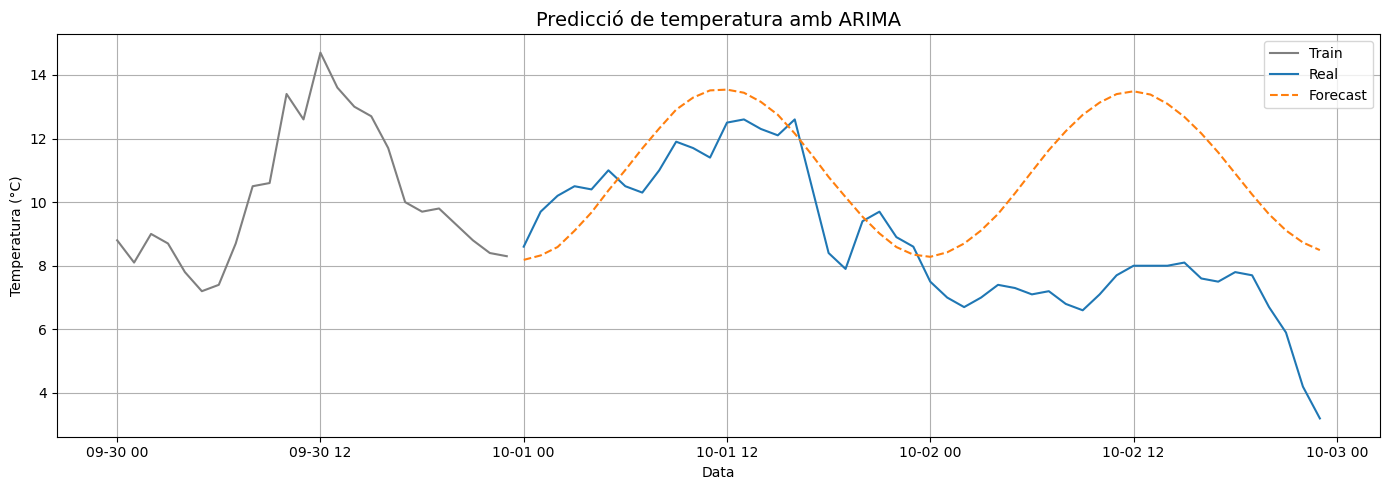

In [14]:
fig = plot_prediccions_arima(
    df_pred,
    df_train=df_train,
    plot_dies_ant=1,
    title="Predicció de temperatura amb ARIMA",
    xlabel="Data",
    ylabel="Temperatura (°C)",
    show=True
)

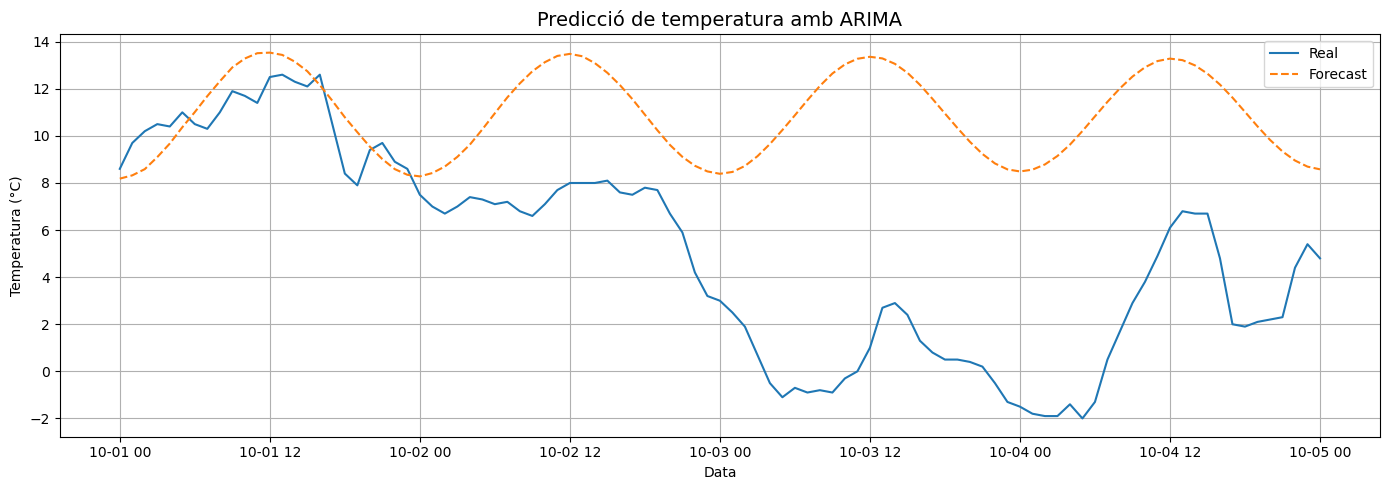

(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7cd75ede0650>,
                           data  valor
 0    2024-08-02 00:00:00+00:00  16.00
 1    2024-08-02 01:00:00+00:00  15.50
 2    2024-08-02 02:00:00+00:00  15.50
 3    2024-08-02 03:00:00+00:00  14.70
 4    2024-08-02 04:00:00+00:00  14.50
 ...                        ...    ...
 1435 2024-09-30 19:00:00+00:00   9.80
 1436 2024-09-30 20:00:00+00:00   9.30
 1437 2024-09-30 21:00:00+00:00   8.80
 1438 2024-09-30 22:00:00+00:00   8.40
 1439 2024-09-30 23:00:00+00:00   8.30
 
 [1440 rows x 2 columns],
                         data  valor  forecast
 0  2024-10-01 00:00:00+00:00   8.60      8.18
 1  2024-10-01 01:00:00+00:00   9.70      8.32
 2  2024-10-01 02:00:00+00:00  10.20      8.59
 3  2024-10-01 03:00:00+00:00  10.50      9.10
 4  2024-10-01 04:00:00+00:00  10.40      9.67
 ..                       ...    ...       ...
 92 2024-10-04 20:00:00+00:00   2.20      9.83
 93 2024-10-04 21:00:00+00:00   2.30      9.34
 9

In [15]:
# Provar la Pipeline

pipeline_arima(
    df=df_arima,
    data_inici_pred ='2024-10-01 00:00:00',
    data_final_pred= '2024-10-05 00:00:00',
    dies_entrenament=60,
    p=10, d=1, q=10,
    P=None, D=None, Q=None, s=None,
    n_passos=150,
    plot_dies_ant=0,
    verbose=False,
    save_path=None,
    show=True)

ℹ️ [0] 'data_final_pred' indicat. Calculant n_passos = 4
🧠 [1/4] Iniciant rolling forecast en blocs de 1 hora/es...
🔁 Reinjecció des de 2024-10-01 00:00:00+00:00 → 1 hora/es
🔁 Reinjecció des de 2024-10-01 01:00:00+00:00 → 1 hora/es
🔁 Reinjecció des de 2024-10-01 02:00:00+00:00 → 1 hora/es
🔁 Reinjecció des de 2024-10-01 03:00:00+00:00 → 1 hora/es
📏 [2/4] Calculant mètriques...
📏 RMSE: 0.48 °C
📏 MSE: 0.23 °C²
📏 MAE: 0.37 °C
📊 [3/4] Generant gràfic de predicció...


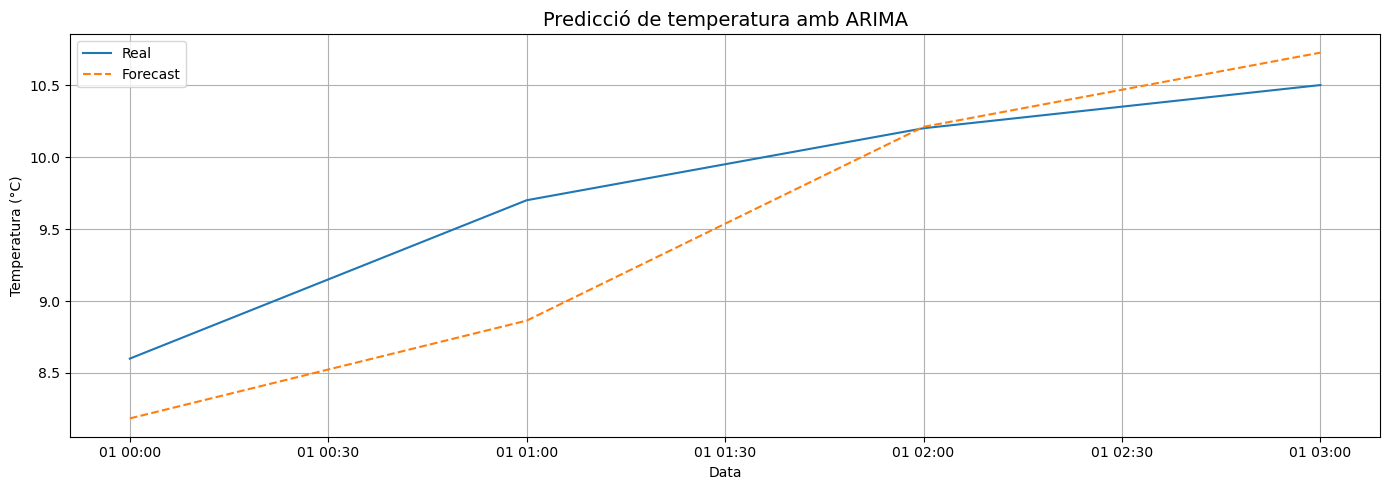

📂 [4/4] Pipeline completada sense guardar resultats.


(                       data  valor  forecast
 0 2024-10-01 00:00:00+00:00   8.60      8.18
 1 2024-10-01 01:00:00+00:00   9.70      8.86
 2 2024-10-01 02:00:00+00:00  10.20     10.21
 3 2024-10-01 03:00:00+00:00  10.50     10.73,
    RMSE  MSE  MAE
 0  0.48 0.23 0.37,
 <Figure size 1400x500 with 1 Axes>)

In [16]:
pipeline_rolling_forecast_arima(
    df=df_arima,
    data_inici_pred='2024-10-01 00:00:00',
    data_final_pred='2024-10-01 03:00:00',
    dies_entrenament=60,
    p=10, d=1, q=10,
    P=None, D=None, Q=None, s=None,
    plot_dies_ant=0,
    pas_pred=1,
    n_passos=24,
    verbose=True,
    save_path=None,
    show=True)


# Experments ARIMA i SARIMA

In [ ]:
# Paràmetres

data_inici_pred = '2024-10-01 00:00:00' # Data on tambe començaran els models LSTM per comparar

dies_entrenament = 60  # Dies d'entrenament per ARIMA

p = 10
d = 1
q = 10

P = None
D = None
Q = None
s = 24    # Perquè les dades son horàries i s=24 per fer-ho diari, es la estacionalitat
